In [17]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import *
import numpy as np 
from matplotlib import pyplot as plt
from IPython.display import clear_output
import pickle
import glob
import datetime

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# The below code allows us to import functions from python files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

vis_tools = drive.CreateFile({'id':'1Pj2xsMXrEUgSjdJ65jecC5WXB2jy5sw8'})
vis_tools.GetContentFile('VisualisationTools.py')
import VisualisationTools
plot_losses = VisualisationTools.PlotLearning()

2.2.0-rc2
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Load image tensors

path = "/content/gdrive/My Drive/Deepfakes Capstone Project"

with open(path + '/DeepFake-2019-20/Pickles/image_tensors.pickle', 'rb') as handle:
  x_data = pickle.load(handle)

with open(path + '/DeepFake-2019-20/Pickles/ori_count.pickle', 'rb') as handle:
  ori_count = pickle.load(handle)

# Specify the parameters and process the data
batch_size = 32
epochs = 40
data_augmentation = True

# Normalise data 
x_data = x_data.astype('float32')
x_data /= 255
manip_count = x_data.shape[0]-ori_count
y_data = np.append(np.array([0]*ori_count), np.array([1]*manip_count))
y_data.shape
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33)
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [26]:
# Remove previously saved weights
!rm -rf '/content/gdrive/My Drive/Deepfakes Capstone Project/SavedWeights/Xception/'
!mkdir '/content/gdrive/My Drive/Deepfakes Capstone Project/SavedWeights/Xception/'

# Remove previous TensorBoard Callback info
!rm -rf '/content/gdrive/My Drive/Deepfakes Capstone Project/TensorBoardCallbacks/Xception/'
!mkdir '/content/gdrive/My Drive/Deepfakes Capstone Project/TensorBoardCallbacks/Xception/'

# Create TensorBoard callback
board_dir = '/content/gdrive/My Drive/Deepfakes Capstone Project/\
TensorBoardCallbacks/Xception/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
t_board = tf.keras.callbacks.TensorBoard(log_dir=board_dir, histogram_freq=1)

34152

In [0]:
# Train all parameters of Xception
from tensorflow.keras.applications.xception import Xception

conv_base = Xception(weights='imagenet', include_top=False,
                     input_shape=(71, 71, 3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Save weights
filepath="/content/gdrive/My Drive/Deepfakes Capstone \
Project/SavedWeights/Xception/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

# # Load weights
# model.load_weights("/content/gdrive/My Drive/Deepfakes Capstone \
# Project/SavedWeights/ResNetAllLayers/epochs:024-val_acc:0.748.hdf5")

# NEED TO USE THE LEARNING RATE SCHEDULER BELOW
# ALSO ADD A GLOBAL AVERAGE POOLING LAYER WHICH WILL BE LESS EXPENSIVE THAN
# A DENSE LAYER AT THE END BUT WILL WORK AS WELL
# lr decay function
# def lr_decay(epoch):
#   return 0.01 * math.pow(0.6, epoch)

# # lr schedule callback
# lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# # important to see what you are doing
# plot_learning_rate(lr_decay, EPOCHS)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[plot_losses, checkpoint, t_board])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
              epochs=epochs,
              validation_data=(x_test, y_test),
              workers=4,
              callbacks=[plot_losses, checkpoint, t_board])

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/40
      2/Unknown - 0s 145ms/step - loss: 0.7829 - accuracy: 0.6250WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.102755). Check your callbacks.
  18237/Unknown - 1681s 92ms/step - loss: 0.0696 - accuracy: 0.9632

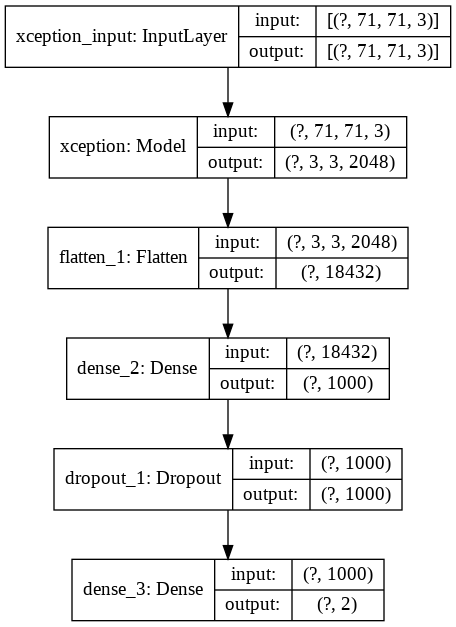

In [0]:
# tf.keras.utils.plot_model(model, show_shapes=True)
%tensorboard --logdir '/content/gdrive/My Drive/Deepfakes Capstone Project\/TensorBoardCallbacks/Xception/'
